#**Building a CNN in Pytorch**


In this notebook, we’ll build and compare **three different Convolutional Neural Networks (CNNs)** of increasing complexity using the **CIFAR-10** dataset. By the end, we’ll:

1. Understand how to set up and load the CIFAR-10 dataset in PyTorch.  
2. Implement and train multiple CNN architectures (Small, Medium, Large).  
3. Evaluate performance with accuracy metrics, including per-class accuracy.  
4. Compare model results visually and save the best-performing model.

This is a hands-on exploration of CNNs and is a stepping stone to more advanced computer vision tasks.

---

##📚 **Library Overview**

- **PyTorch** ([Documentation](https://pytorch.org/docs/stable/))  
  - **`torch`**: Core tensor functionality, module definitions (`nn.Module`), optimizers.  
  - **`torchvision`**: Provides common datasets like CIFAR-10 and useful image transformations.  
- **Matplotlib** ([Documentation](https://matplotlib.org/)): For data visualization (training loss plots, sample images, etc.).  
- **Python Standard Libraries**:
  - **`time`**: Timing how long training takes.  
  - **`random`** or **`torch.manual_seed`** for reproducibility.

We take advantage of **GPU acceleration** if available (`torch.cuda.is_available()`).



## **Imports, Random Seed, and GPU Availability**


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

# Set random seed for reproducibility
torch.manual_seed(42)

# Function to check if GPU is available
def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("GPU not available, using CPU instead")
    return device


**Explanation:**

1. **Imports**:
   - **`torch`**, **`torch.nn`**, **`torch.optim`**: Core PyTorch functionalities for building and training neural networks.
   - **`torchvision`**: Provides popular datasets (like CIFAR-10) and transforms.
   - **`matplotlib`** and **`numpy`**: For visualizing data and handling arrays.
   - **`time`**: To measure training duration.

2. **`torch.manual_seed(42)`**: Ensures some level of reproducibility.

3. **`get_device()`** function:
   - Checks if a GPU is available.
   - Prints GPU info if `cuda` is found, otherwise uses CPU.


## **Data Loading**


In [2]:
def load_data(batch_size=128):
    # Data transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load training dataset
    trainset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )
    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    # Load test dataset
    testset = torchvision.datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    # Class names
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    return trainloader, testloader, classes


**Explanation:**

- **CIFAR-10** dataset has 60,000 color images in 10 classes, with 50,000 for training and 10,000 for testing.
- **`transforms.ToTensor()`** converts images to PyTorch tensors.
- **`transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`** normalizes each channel (RGB) to have mean 0.5 and std 0.5.
- **`DataLoader`**:
  - **`trainloader`** with `shuffle=True` for random batching in training.
  - **`testloader`** with `shuffle=False` since order doesn’t matter for testing.
- **`classes`**: Tuple of class labels.


## **Visualizing a Batch of Images**


In [3]:
def show_images(dataloader, classes):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    img = torchvision.utils.make_grid(images[:5])
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()

    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(' '.join(f'{classes[labels[j]]}' for j in range(5)))
    plt.axis('off')
    plt.show()


**Explanation:**

- Retrieves a batch from the **`dataloader`**.
- **`torchvision.utils.make_grid`** arranges the first 5 images in a grid.
- **`img = img / 2 + 0.5`** reverts the normalization to display human-readable images.
- Plots them with their class names as titles using **`matplotlib`**.


## **CNN Model Definitions (Small, Medium, Large)**


In [4]:
# Small CNN
class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        self.name = "Small CNN"

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(-1, 32 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x


# Medium CNN
class MediumCNN(nn.Module):
    def __init__(self):
        super(MediumCNN, self).__init__()
        self.name = "Medium CNN"

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

        # Activation
        self.relu = nn.ReLU()

        # Dropout
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = self.relu(self.conv3(x))
        x = self.pool(x)

        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


# Large CNN
class LargeCNN(nn.Module):
    def __init__(self):
        super(LargeCNN, self).__init__()
        self.name = "Large CNN"

        # First convolutional block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Second block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # Third block
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)

        # Pool
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.bnfc1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bnfc2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 10)

        # ReLU
        self.relu = nn.ReLU()

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Block 1
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        # Block 2
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        # Block 3
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)

        # Flatten
        x = x.view(-1, 256 * 4 * 4)

        # FC layers with batchnorm & dropout
        x = self.relu(self.bnfc1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bnfc2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)

        return x


**Explanation:**

We define three different CNN architectures of varying complexity:

1. **SmallCNN**:
   - **2 convolutional layers** with max pooling.
   - **1 fully connected** hidden layer (128 neurons).
   - Quick to train but lower capacity.

2. **MediumCNN**:
   - **3 convolutional layers** → max pooling after each.  
   - **1 fully connected** hidden layer (512 neurons) + **dropout** (0.25) to reduce overfitting.

3. **LargeCNN**:
   - Multiple convolution blocks (3 blocks × 2 conv layers each).
   - **Batch normalization** after each convolution and fully connected layer.  
   - **Dropout** = 0.5 for more aggressive regularization.
   - Significantly larger capacity, potentially higher accuracy, but also more compute cost.


## **Training Function**


In [5]:
def train_model(model, trainloader, device, epochs=5, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    print(f"Training {model.name} for {epochs} epochs...")
    start_time = time.time()

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy so far
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Print stats every 100 mini-batches
            if (i + 1) % 100 == 0:
                batch_loss = running_loss / 100
                batch_acc = 100.0 * correct / total
                print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {batch_loss:.3f}, Accuracy: {batch_acc:.2f}%")
                train_losses.append(batch_loss)
                running_loss = 0.0
                correct = 0
                total = 0

    time_elapsed = time.time() - start_time
    print(f"Training complete in {time_elapsed:.2f} seconds")

    return model, train_losses


**Explanation:**

1. **`train_model`**:
   - **`criterion = nn.CrossEntropyLoss()`**: Standard multi-class classification loss.
   - **`optimizer = optim.Adam(...)`**: Uses Adam to adapt the learning rates of each parameter.
   - Iterates over **`epochs`** and mini-batches:
     - **Forward pass** → **loss** → **backward pass** → **optimizer.step()**.
     - Tracks **running_loss** and **accuracy** within each epoch.
     - Prints stats every 100 batches.
   - **`train_losses`** list holds the average loss every 100 batches, useful for plotting.
   - Returns **`model`** and **`train_losses`** after training completes, along with elapsed time for logging.


##**Evaluation Function**

In [6]:
def evaluate_model(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    accuracy = 100.0 * correct / total
    print(f"\nTest Accuracy of {model.name}: {accuracy:.2f}%")
    return accuracy, class_correct, class_total


**Explanation:**

- **`model.eval()`**: Disables dropout / batchnorm updates.
- **`with torch.no_grad():`**: No gradient tracking is needed for inference.
- Tracks:
  - **`correct`** / **`total`** for overall accuracy.
  - **`class_correct`** / **`class_total`** to compute per-class accuracies.
- Prints overall test accuracy and returns accuracy + class-wise stats.


## **Class-Wise Accuracy**


In [7]:
def display_class_accuracy(class_correct, class_total, classes):
    for i in range(10):
        if class_total[i] > 0:
            print(f'Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')


**Explanation:**

- Loops through each class index from 0 to 9.
- Calculates **accuracy** = \(\frac{\text{class_correct}[i]}{\text{class_total}[i]} \times 100\%\).
- Prints individual class accuracies to identify where the model performs well vs. poorly.


## **Training Loss Plot**


In [8]:
def plot_loss(losses, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label=f'{model_name} Training Loss')
    plt.title(f'Training Loss for {model_name}')
    plt.xlabel('Iterations (x100 batches)')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


**Explanation:**

- Plots the **training loss** collected every 100 batches.  
- **`Iterations (x100 batches)`** indicates each point corresponds to 100 mini-batches.  
- Good for a quick look at whether the model is converging or if it might need more training epochs.


## **Comparing Model Accuracies**


In [9]:
def compare_models(accuracies):
    plt.figure(figsize=(10, 5))
    plt.bar(accuracies.keys(), accuracies.values())
    plt.title('Model Comparison')
    plt.xlabel('Model')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)
    for i, v in enumerate(accuracies.values()):
        plt.text(i, v + 1, f"{v:.2f}%", ha='center')
    plt.show()


**Explanation:**

- Accepts a dictionary of **model_name → accuracy**.  
- Creates a **bar chart** with accuracy on the y-axis.  
- Places the numeric accuracy above each bar for clarity.


## **Main Execution**


Using GPU: Tesla T4
Loading CIFAR-10 dataset...


100%|██████████| 170M/170M [00:03<00:00, 49.0MB/s]


Displaying sample images...


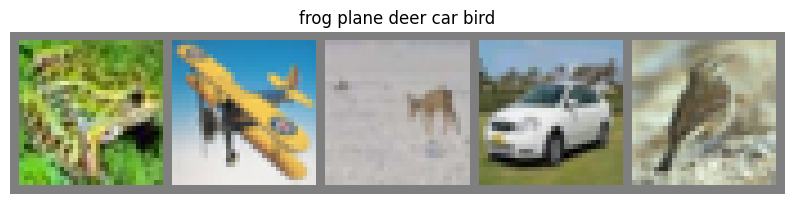

Training Small CNN for 3 epochs...
[Epoch 1, Batch 100] Loss: 1.892, Accuracy: 31.72%
[Epoch 1, Batch 200] Loss: 1.559, Accuracy: 43.77%
[Epoch 1, Batch 300] Loss: 1.475, Accuracy: 46.44%
[Epoch 1, Batch 400] Loss: 1.380, Accuracy: 49.55%
[Epoch 1, Batch 500] Loss: 1.348, Accuracy: 50.97%
[Epoch 1, Batch 600] Loss: 1.277, Accuracy: 54.27%
[Epoch 1, Batch 700] Loss: 1.253, Accuracy: 55.45%
[Epoch 2, Batch 100] Loss: 1.189, Accuracy: 57.31%
[Epoch 2, Batch 200] Loss: 1.133, Accuracy: 60.53%
[Epoch 2, Batch 300] Loss: 1.100, Accuracy: 59.98%
[Epoch 2, Batch 400] Loss: 1.105, Accuracy: 60.62%
[Epoch 2, Batch 500] Loss: 1.114, Accuracy: 61.39%
[Epoch 2, Batch 600] Loss: 1.069, Accuracy: 62.00%
[Epoch 2, Batch 700] Loss: 1.061, Accuracy: 62.41%
[Epoch 3, Batch 100] Loss: 0.988, Accuracy: 65.09%
[Epoch 3, Batch 200] Loss: 0.973, Accuracy: 66.39%
[Epoch 3, Batch 300] Loss: 0.961, Accuracy: 66.20%
[Epoch 3, Batch 400] Loss: 0.958, Accuracy: 66.08%
[Epoch 3, Batch 500] Loss: 0.944, Accuracy: 66.

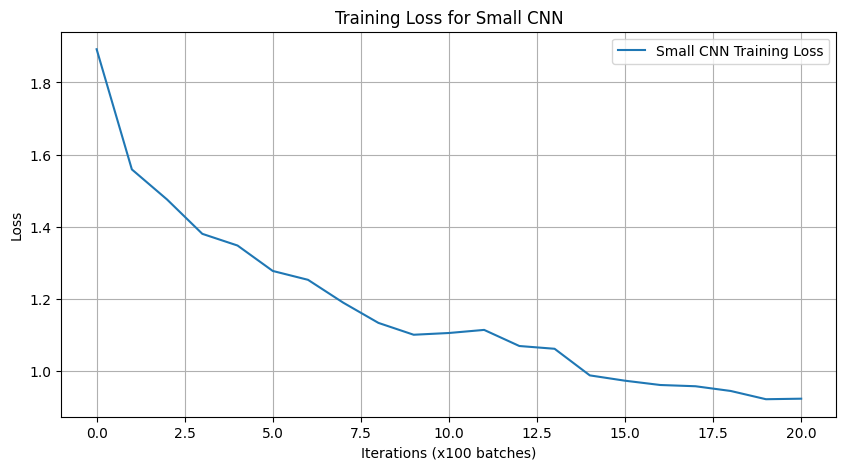

Training Medium CNN for 3 epochs...
[Epoch 1, Batch 100] Loss: 1.922, Accuracy: 28.92%
[Epoch 1, Batch 200] Loss: 1.550, Accuracy: 43.34%
[Epoch 1, Batch 300] Loss: 1.413, Accuracy: 49.48%
[Epoch 1, Batch 400] Loss: 1.348, Accuracy: 50.62%
[Epoch 1, Batch 500] Loss: 1.252, Accuracy: 55.70%
[Epoch 1, Batch 600] Loss: 1.188, Accuracy: 58.16%
[Epoch 1, Batch 700] Loss: 1.145, Accuracy: 59.08%
[Epoch 2, Batch 100] Loss: 1.030, Accuracy: 63.36%
[Epoch 2, Batch 200] Loss: 1.006, Accuracy: 64.56%
[Epoch 2, Batch 300] Loss: 0.948, Accuracy: 66.91%
[Epoch 2, Batch 400] Loss: 0.970, Accuracy: 65.89%
[Epoch 2, Batch 500] Loss: 0.942, Accuracy: 66.67%
[Epoch 2, Batch 600] Loss: 0.905, Accuracy: 67.97%
[Epoch 2, Batch 700] Loss: 0.889, Accuracy: 69.16%
[Epoch 3, Batch 100] Loss: 0.774, Accuracy: 72.89%
[Epoch 3, Batch 200] Loss: 0.781, Accuracy: 72.61%
[Epoch 3, Batch 300] Loss: 0.758, Accuracy: 73.05%
[Epoch 3, Batch 400] Loss: 0.790, Accuracy: 71.77%
[Epoch 3, Batch 500] Loss: 0.762, Accuracy: 73

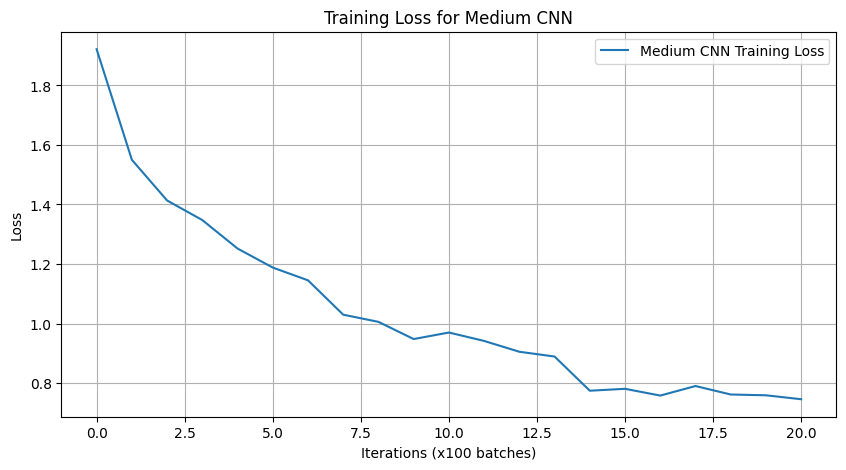

Training Large CNN for 3 epochs...
[Epoch 1, Batch 100] Loss: 1.760, Accuracy: 35.66%
[Epoch 1, Batch 200] Loss: 1.446, Accuracy: 47.69%
[Epoch 1, Batch 300] Loss: 1.248, Accuracy: 54.67%
[Epoch 1, Batch 400] Loss: 1.163, Accuracy: 58.80%
[Epoch 1, Batch 500] Loss: 1.043, Accuracy: 62.89%
[Epoch 1, Batch 600] Loss: 0.950, Accuracy: 66.94%
[Epoch 1, Batch 700] Loss: 0.935, Accuracy: 67.22%
[Epoch 2, Batch 100] Loss: 0.833, Accuracy: 70.81%
[Epoch 2, Batch 200] Loss: 0.805, Accuracy: 71.80%
[Epoch 2, Batch 300] Loss: 0.753, Accuracy: 73.64%
[Epoch 2, Batch 400] Loss: 0.738, Accuracy: 73.92%
[Epoch 2, Batch 500] Loss: 0.723, Accuracy: 74.95%
[Epoch 2, Batch 600] Loss: 0.701, Accuracy: 75.78%
[Epoch 2, Batch 700] Loss: 0.679, Accuracy: 77.25%
[Epoch 3, Batch 100] Loss: 0.602, Accuracy: 78.67%
[Epoch 3, Batch 200] Loss: 0.569, Accuracy: 80.17%
[Epoch 3, Batch 300] Loss: 0.595, Accuracy: 79.45%
[Epoch 3, Batch 400] Loss: 0.589, Accuracy: 79.81%
[Epoch 3, Batch 500] Loss: 0.581, Accuracy: 80.

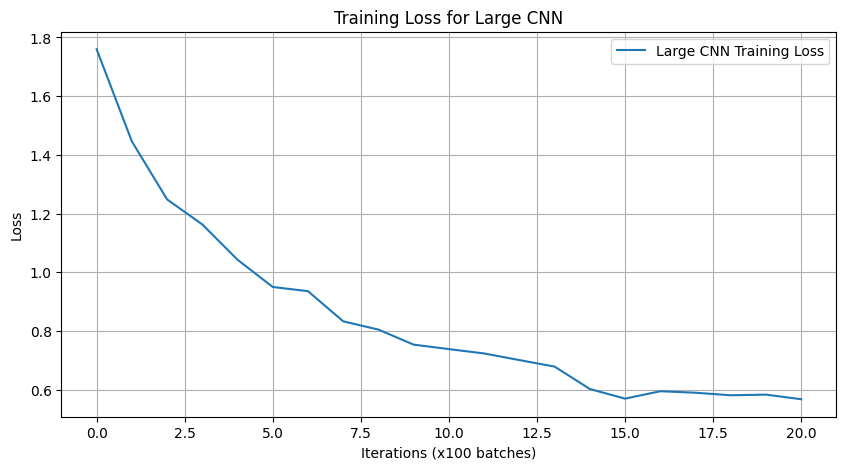

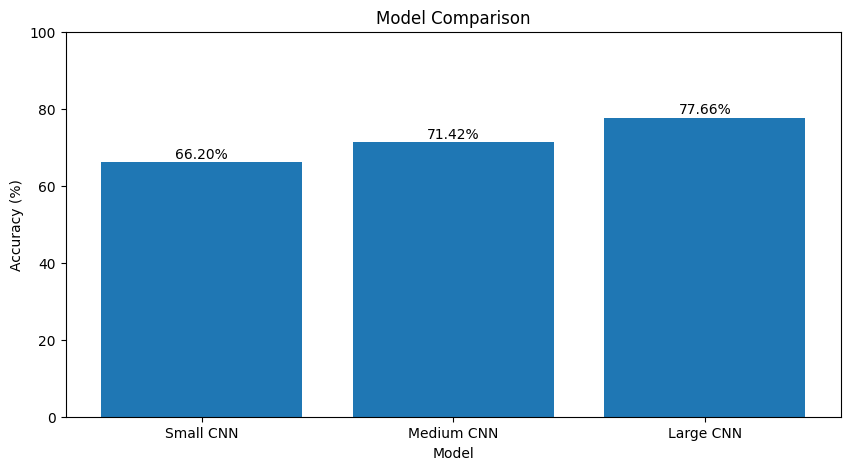


Saving the best model: Large CNN
Model saved as large_cnn.pth


In [10]:
def main():
    # Set up device
    device = get_device()

    # Load data
    print("Loading CIFAR-10 dataset...")
    trainloader, testloader, classes = load_data(batch_size=64)

    # Show some example images
    print("Displaying sample images...")
    show_images(trainloader, classes)

    # Dictionary to store accuracies for comparison
    model_accuracies = {}

    # Train and evaluate Small CNN
    small_cnn = SmallCNN().to(device)
    trained_small_cnn, small_losses = train_model(small_cnn, trainloader, device, epochs=3)
    small_acc, small_class_correct, small_class_total = evaluate_model(trained_small_cnn, testloader, device)
    display_class_accuracy(small_class_correct, small_class_total, classes)
    plot_loss(small_losses, small_cnn.name)
    model_accuracies[small_cnn.name] = small_acc

    # Train and evaluate Medium CNN
    medium_cnn = MediumCNN().to(device)
    trained_medium_cnn, medium_losses = train_model(medium_cnn, trainloader, device, epochs=3)
    medium_acc, medium_class_correct, medium_class_total = evaluate_model(trained_medium_cnn, testloader, device)
    display_class_accuracy(medium_class_correct, medium_class_total, classes)
    plot_loss(medium_losses, medium_cnn.name)
    model_accuracies[medium_cnn.name] = medium_acc

    # Train and evaluate Large CNN
    large_cnn = LargeCNN().to(device)
    trained_large_cnn, large_losses = train_model(large_cnn, trainloader, device, epochs=3)
    large_acc, large_class_correct, large_class_total = evaluate_model(trained_large_cnn, testloader, device)
    display_class_accuracy(large_class_correct, large_class_total, classes)
    plot_loss(large_losses, large_cnn.name)
    model_accuracies[large_cnn.name] = large_acc

    # Compare models
    compare_models(model_accuracies)

    # Save the best model
    best_model_name = max(model_accuracies, key=model_accuracies.get)
    if best_model_name == "Small CNN":
        best_model = trained_small_cnn
    elif best_model_name == "Medium CNN":
        best_model = trained_medium_cnn
    else:
        best_model = trained_large_cnn

    print(f"\nSaving the best model: {best_model_name}")
    torch.save(best_model.state_dict(), f"{best_model_name.replace(' ', '_').lower()}.pth")
    print(f"Model saved as {best_model_name.replace(' ', '_').lower()}.pth")

if __name__ == "__main__":
    main()


**Explanation:**

1. **`get_device()`**: Determines if we use CPU or GPU.
2. **`load_data(...)`**: Downloads and transforms CIFAR-10 data.
3. **`show_images(...)`**: Displays a sample of images.
4. **Model training**:
   - **`train_model`** is called for **SmallCNN**, **MediumCNN**, **LargeCNN** (3 epochs each).  
   - Logs training losses and updates **model_accuracies** with test results.
5. **Comparison**:
   - **`compare_models(model_accuracies)`** creates a bar chart of final accuracies.
   - Saves the **best model** based on accuracy into a `.pth` file.


##📚 **Additional Reading & Resources**

- **PyTorch Tutorials**: [https://pytorch.org/tutorials/](https://pytorch.org/tutorials/)  
  Official tutorials covering CNNs, data loading, and more.

- **Stanford CS231n**: [Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/)  
  Detailed explanation of CNN fundamentals, from convolutions to advanced architectures.

- **Kaggle**:  
  - [CIFAR‑10 – Basic CNN with PyTorch (by icofield)](https://www.kaggle.com/code/icofield/cifar-10-basic-cnn-with-pytorch/notebook)


- **Deep Learning Book** by Ian Goodfellow et al. ([online](http://www.deeplearningbook.org/))  
  Comprehensive theory on CNNs, regularization, and more.
